In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from trades_to_ohlc import (trades_to_time_ohlcv, 
                            trades_to_ohlc_volume, 
                            trades_to_tick_imbalance_bars,
                            trades_to_volume_imbalance_bars,
                            trades_to_dollar_imbalance_bars
                            )

import mplfinance as mpf

In [2]:
df = pd.read_csv('../data/test_trades_data.zip', compression='zip')

# 2.1

(The main solution is located in *trades_to_ohlc* module)

On a series of E-mini S&P 500 futures tick data:
- (a) Form tick, volume, and dollar bars. Use the ETF trick to deal with the roll.

Standard bars

In [3]:
df_time = trades_to_time_ohlcv(df)

/media/dima/USB DISK/de_prado_solutions/Chapter_2/trades_to_ohlc.py:28: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ohlcv = df_trades.resample(time_frame).agg(


Volume bars

In [10]:
df_vol = trades_to_ohlc_volume(df, 10_000, dollar_vol=False)
df_vol_dol = trades_to_ohlc_volume(df, 100_000, dollar_vol=True)

In [5]:
df_tick_imb = trades_to_tick_imbalance_bars(df, 500)

In [6]:
df_vol_imb = trades_to_volume_imbalance_bars(df, 1000)
df_dol_imb = trades_to_dollar_imbalance_bars(df, 10000)

- (b) Count the number of bars produced by tick, volume, and dollar bars on a weekly basis. Plot a time series of that bar count. What bar type produces the most stable weekly count? Why?


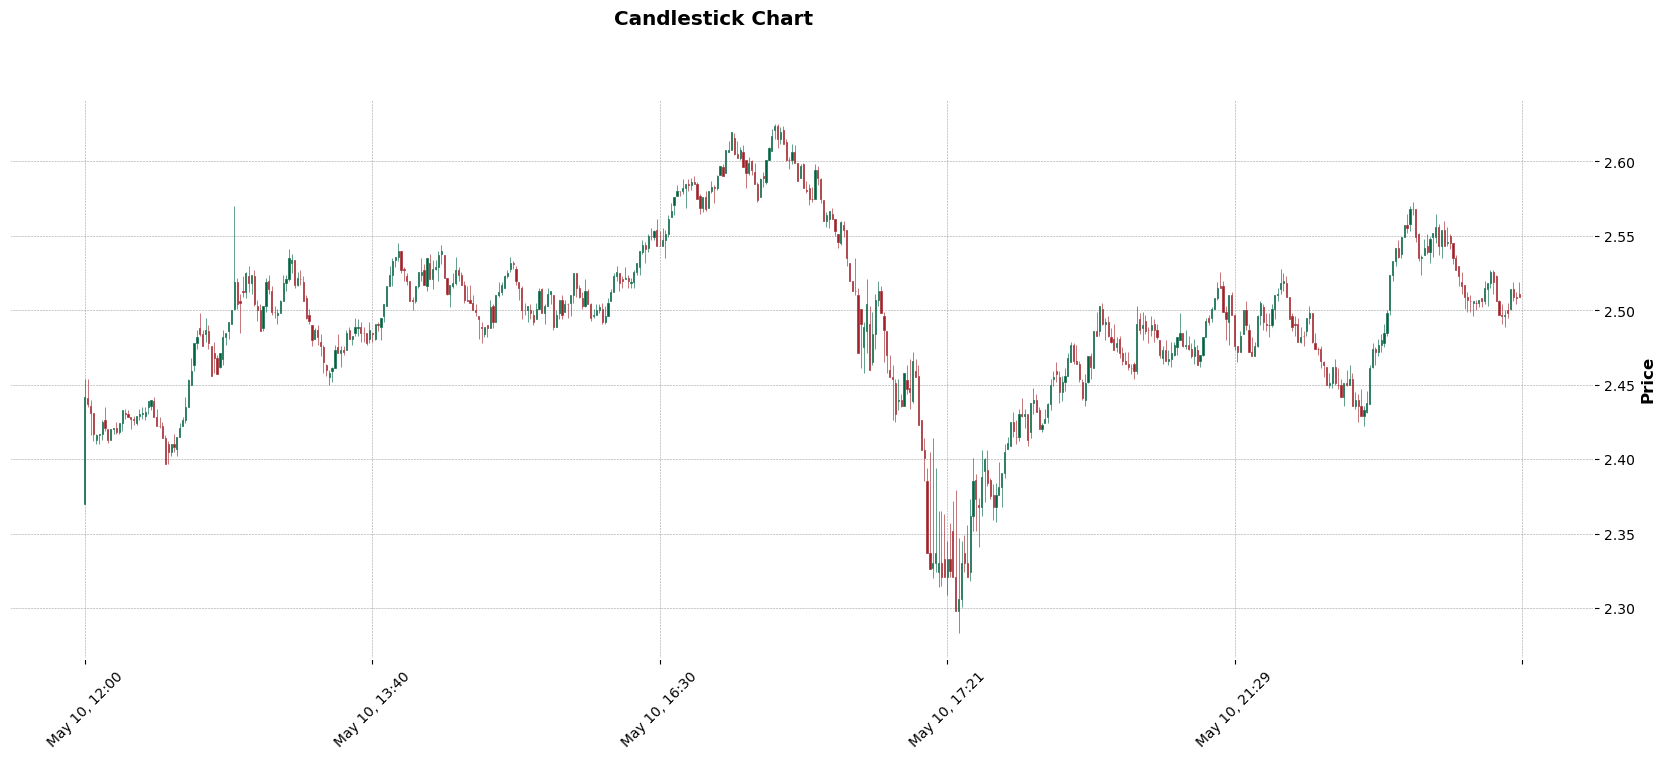

In [15]:
mpf.plot(df_vol[:500], type='candle', style='charles', title='Candlestick Chart', ylabel='Price', figsize=(22, 8))

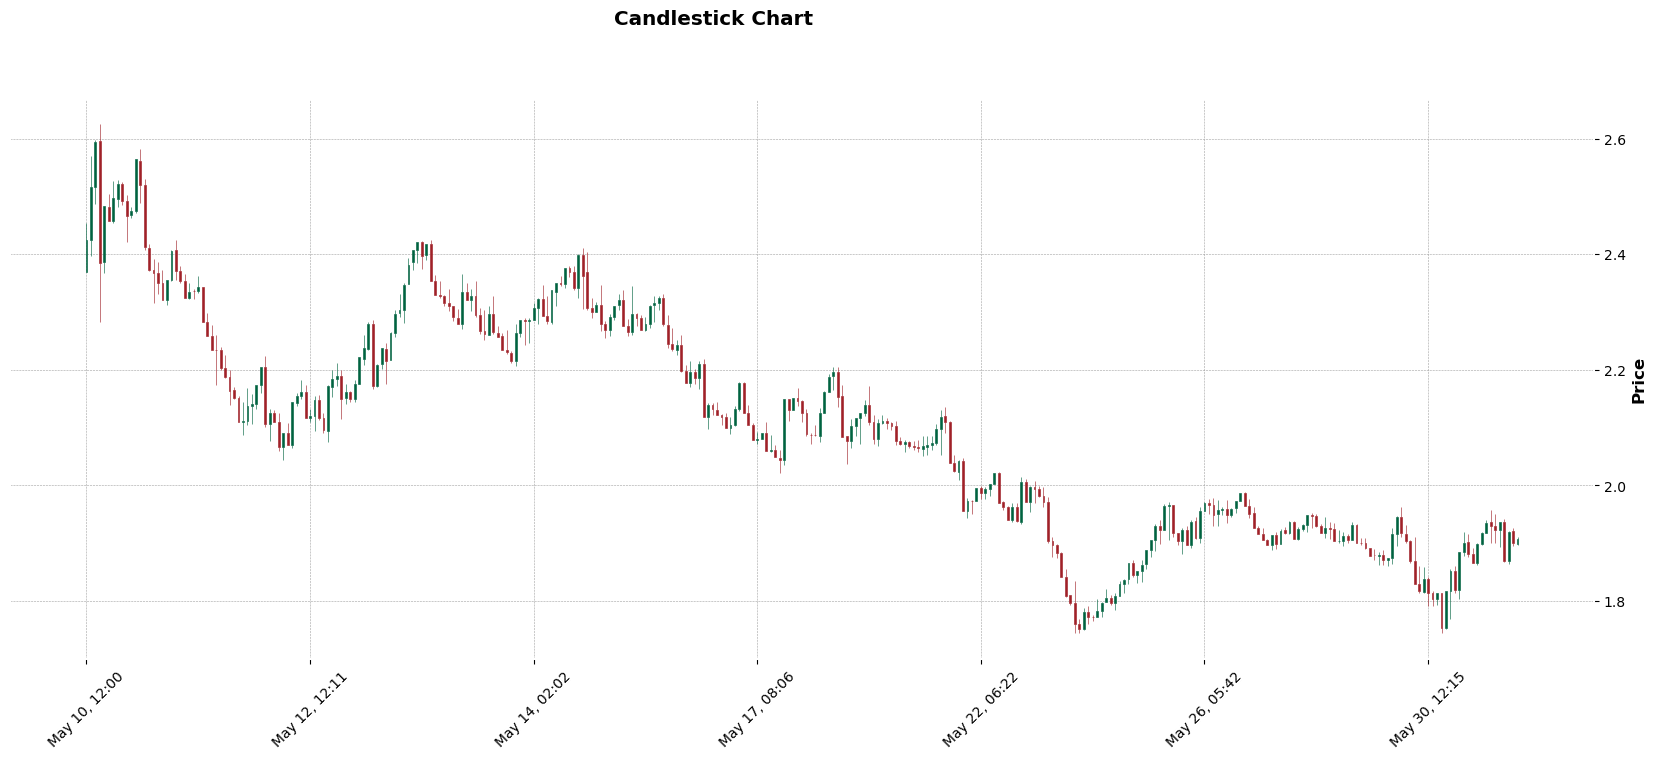

In [20]:
mpf.plot(df_tick_imb[:500], type='candle', style='charles', title='Candlestick Chart', ylabel='Price', figsize=(22, 8))

- (c) Compute the serial correlation of returns for the three bar types. What bar method has the lowest serial correlation

In [8]:
def compute_autocorrelation(df_bars, lag=1):
    returns = df_bars['Close'].pct_change().dropna()
    return returns.autocorr(lag)



autocorr_time    = compute_autocorrelation(df_time)
autocorr_vol     = compute_autocorrelation(df_vol)
autocorr_vol_dol = compute_autocorrelation(df_vol_dol)
autocorr_tick    = compute_autocorrelation(df_tick_imb)
autocorr_vol_imb = compute_autocorrelation(df_vol_imb)

print("Autocorrelation of returns (lag=1) for different bar types:")
print(f"Time bars:             {autocorr_time:.4f}")
print(f"Volume bars:           {autocorr_vol:.4f}")
print(f"Dollar volume bars:    {autocorr_vol_dol:.4f}")
print(f"Tick imbalance bars:   {autocorr_tick:.4f}")
print(f"Volume imbalance bars: {autocorr_vol_imb:.4f}")

Autocorrelation of returns (lag=1) for different bar types:
Time bars:             -0.0620
Volume bars:           0.0000
Dollar volume bars:    -0.0386
Tick imbalance bars:   -0.1312
Volume imbalance bars: -0.0836


- (d) Partition the bar series into monthly subsets. Compute the variance of returns for every subset of every bar type. Compute the variance of those variances. What method exhibits the smallest variance of variances?
- (e) Apply the Jarque-Bera normality test on returns from the three bar types. What method achieves the lowest test statistic?

In [23]:
def variance_of_variances(df_bars):
    """
    Given a bar DataFrame with a datetime index and a 'Close' column,
    compute the monthly variance of returns and then return the variance
    of these monthly variances.
    
    Returns a tuple:
      (overall_variance_of_monthly_variances, monthly_variances_series)
    """
    # Compute returns from the close prices
    returns = df_bars['Close'].pct_change().dropna()
    # Group returns by month (using PeriodIndex with monthly frequency)
    monthly_variances = returns.groupby(returns.index.to_period('W')).var()
    # Compute the variance of the monthly variances
    var_of_vars = monthly_variances.var()
    return var_of_vars, monthly_variances

# Compute variance-of-variances for each bar type:
var_var_time, monthly_var_time       = variance_of_variances(df_time)
var_var_vol, monthly_var_vol         = variance_of_variances(df_vol)
var_var_vol_dol, monthly_var_vol_dol = variance_of_variances(df_vol_dol)
var_var_tick, monthly_var_tick       = variance_of_variances(df_tick_imb)
var_var_vol_imb, monthly_var_vol_imb = variance_of_variances(df_vol_imb)

# Print results:
print("Variance of Monthly Return Variances (lower is better):")
print(f"Time-based bars:            {var_var_time:.6f}")
print(f"Volume-based bars:          {var_var_vol:.6f}")
print(f"Dollar volume-based bars:   {var_var_vol_dol:.6f}")
print(f"Tick imbalance bars:        {var_var_tick:.6f}")
print(f"Volume imbalance bars:      {var_var_vol_imb:.6f}")

# Determine which method has the smallest variance-of-variances:
results = {
    "Time-based": var_var_time,
    "Volume-based": var_var_vol,
    "Dollar Volume-based": var_var_vol_dol,
    "Tick Imbalance": var_var_tick,
    "Volume Imbalance": var_var_vol_imb
}

best_method = min(results, key=results.get)
print(f"\nThe method with the smallest variance of variances is: {best_method}")


Variance of Monthly Return Variances (lower is better):
Time-based bars:            0.000000
Volume-based bars:          0.000000
Dollar volume-based bars:   0.000000
Tick imbalance bars:        0.000000
Volume imbalance bars:      0.000000

The method with the smallest variance of variances is: Volume Imbalance


In [34]:
from scipy.stats import jarque_bera

def jarque_bera_statistic(df_bars):
    returns = df_bars['Close'].pct_change().dropna()
    jb_stat, p_value = jarque_bera(returns)
    return returns, jb_stat, p_value

# Compute JB test for each bar type:
ret_time, jb_time, p_time    = jarque_bera_statistic(df_time)
ret_vol, jb_vol, p_vol      = jarque_bera_statistic(df_vol)
ret_imb, jb_tick, p_tick    = jarque_bera_statistic(df_tick_imb)

print("Jarque-Bera Test Statistics (lower is better):")
print(f"Time-based bars:           JB stat = {jb_time:.4f}, p-value = {p_time:.4f}")
print(f"Volume-based bars:         JB stat = {jb_vol:.4f}, p-value = {p_vol:.4f}")
print(f"Tick imbalance bars:       JB stat = {jb_tick:.4f}, p-value = {p_tick:.4f}")

# Determine which bar type achieves the lowest JB statistic:
stats = {
    "Time-based": jb_time,
    "Volume-based": jb_vol,
    "Tick imbalance": jb_tick
}
best_method = min(stats, key=stats.get)
print(f"\nThe bar type with the lowest Jarque-Bera statistic is: {best_method}")


Jarque-Bera Test Statistics (lower is better):
Time-based bars:           JB stat = 308899.0137, p-value = 0.0000
Volume-based bars:         JB stat = 9453.4962, p-value = 0.0000
Tick imbalance bars:       JB stat = 123.1396, p-value = 0.0000

The bar type with the lowest Jarque-Bera statistic is: Tick imbalance


The results do not make much sense. A more consistent approach would be to construct bars for different values of thresholds and check statistics on that.

# 2.2 

On a series of E-mini S&P 500 futures tick data, compute dollar bars
and dollar imbalance bars. What bar type exhibits greater serial correlation?
Why?

In [9]:
compute_autocorrelation(df_vol_dol)

np.float64(-0.038590523869652796)

In [12]:
compute_autocorrelation(df_dol_imb)

np.float64(0.029696022161072377)

Note that we actually use a bit different approach and define threshold as a hyperparameter for the bars computations. Let's check how the autocorrelation coefficient depends on this parameter:


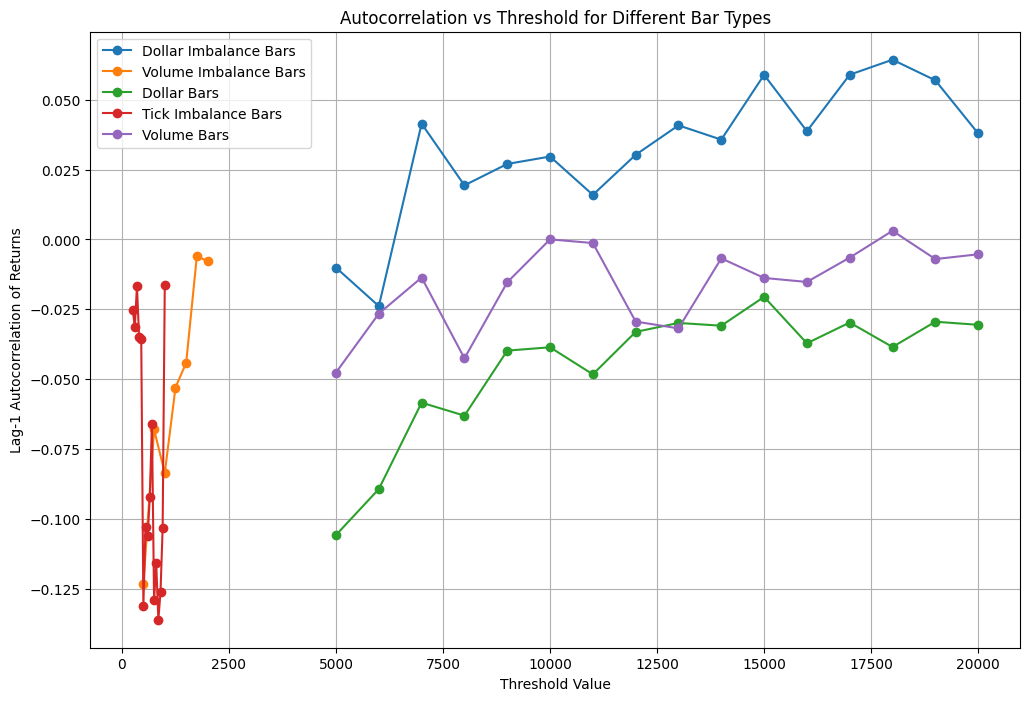

In [13]:
def compute_autocorrelation(df_bars, lag=1):
    """Compute the lag-1 autocorrelation of returns (percentage change of 'Close')."""
    returns = df_bars['Close'].pct_change().dropna()
    return returns.autocorr(lag)

# Define threshold ranges for each bar type (adjust these ranges as appropriate for your data)
thresholds_dol_imb = np.arange(5000, 20001, 1000)      # For dollar imbalance bars
thresholds_vol_imb = np.arange(500, 2001, 250)           # For volume imbalance bars
thresholds_dol     = np.arange(5000, 20001, 1000)        # For dollar bars
thresholds_tick_imb = np.arange(250, 1001, 50)           # For tick imbalance bars
thresholds_vol     = np.arange(5000, 20001, 1000)        # For volume bars

# Initialize lists to store autocorrelation values for each method
autocorr_dol_imb = []
for thr in thresholds_dol_imb:
    bars = trades_to_dollar_imbalance_bars(df, thr)
    ac = compute_autocorrelation(bars)
    autocorr_dol_imb.append(ac)

autocorr_vol_imb = []
for thr in thresholds_vol_imb:
    bars = trades_to_volume_imbalance_bars(df, thr)
    ac = compute_autocorrelation(bars)
    autocorr_vol_imb.append(ac)

autocorr_dol = []
for thr in thresholds_dol:
    bars = trades_to_ohlc_volume(df, thr, dollar_vol=True)
    ac = compute_autocorrelation(bars)
    autocorr_dol.append(ac)

autocorr_tick = []
for thr in thresholds_tick_imb:
    bars = trades_to_tick_imbalance_bars(df, thr)
    ac = compute_autocorrelation(bars)
    autocorr_tick.append(ac)

autocorr_vol = []
for thr in thresholds_vol:
    bars = trades_to_ohlc_volume(df, thr, dollar_vol=False)
    ac = compute_autocorrelation(bars)
    autocorr_vol.append(ac)

# Plot the results
plt.figure(figsize=(12,8))
plt.plot(thresholds_dol_imb, autocorr_dol_imb, marker='o', label="Dollar Imbalance Bars")
plt.plot(thresholds_vol_imb, autocorr_vol_imb, marker='o', label="Volume Imbalance Bars")
plt.plot(thresholds_dol, autocorr_dol, marker='o', label="Dollar Bars")
plt.plot(thresholds_tick_imb, autocorr_tick, marker='o', label="Tick Imbalance Bars")
plt.plot(thresholds_vol, autocorr_vol, marker='o', label="Volume Bars")
plt.xlabel("Threshold Value")
plt.ylabel("Lag-1 Autocorrelation of Returns")
plt.title("Autocorrelation vs Threshold for Different Bar Types")
plt.legend()
plt.grid(True)
plt.show()


So, there's something strange. I didn't get how to practically realize the formulas for *T** from the book which should fix the threshold value. This is something needing further investigation.  

###  (a)
Compute Bollinger bands of width 5% around a rolling moving average.
Count how many times prices cross the bands out (from within the bands
to outside the bands).

In [26]:
window = 20  
ma = df_vol_dol['Close'].rolling(window=window).mean()

# Bollinger bands at ±1% around the moving average (note that we take 1%!)
upper_band = ma * 1.01
lower_band = ma * 0.99

# For each bar, check if the previous Close was inside the bands...
inside_prev = (df_vol_dol['Close'].shift(1) >= lower_band.shift(1)) & (df_vol_dol['Close'].shift(1) <= upper_band.shift(1))
# ... and the current Close is outside the bands.
outside_curr = (df_vol_dol['Close'] < lower_band) | (df_vol_dol['Close'] > upper_band)
# Count crossing events (only count when going from inside to outside)
crossings = inside_prev & outside_curr
num_crossings = crossings.sum()
print("Number of price crossings from inside to outside the Bollinger bands:", num_crossings)


Number of price crossings from inside to outside the Bollinger bands: 142


#### (b) 

CUSUM Sampling of Dollar Bars

Next, we sample the dollar bar series using a CUSUM filter. In our setting the returns from the dollar bars are computed as the percentage change of the Close prices. The CUSUM filter works by accumulating returns until the absolute cumulative sum exceeds h = 0.05. We count how many times this condition is met.

In [28]:
def cusum_filter(returns, threshold):
    pos_sum, neg_sum = 0.0, 0.0
    indices = []
    for i, r in enumerate(returns):
        pos_sum = max(0, pos_sum + r)
        neg_sum = min(0, neg_sum + r)
        if pos_sum > threshold or neg_sum < -threshold:
            indices.append(i)
            pos_sum, neg_sum = 0.0, 0.0
    return indices

# Compute returns from the dollar bars (using the 'Close' prices)
returns_dollar = df_vol_dol['Close'].pct_change().dropna().values

# Apply CUSUM with h = 0.05
cusum_indices = cusum_filter(returns_dollar, 0.05)
print("Number of CUSUM samples (h = 0.05):", len(cusum_indices))


Number of CUSUM samples (h = 0.05): 46


# 2.5

In [12]:
def cusum_filter_abs(abs_returns, threshold):
    cumulative_sum = 0.0
    indices = []
    for i, r in enumerate(abs_returns):
        cumulative_sum += r
        if cumulative_sum >= threshold:
            indices.append(i)
            cumulative_sum = 0.0  # reset after a sample is taken
    return indices

# Compute percentage returns from the dollar bars:
returns_dollar = df_vol_dol['Close'].pct_change().dropna()

# Compute absolute returns:
abs_returns = returns_dollar.abs().values

# Apply the CUSUM filter on absolute returns:
threshold_h = 0.05
sampled_indices = cusum_filter_abs(abs_returns, threshold_h)

# Sample the bars at these indices. Note: since returns start from the second observation,
# you might want to adjust the indices if needed.
df_dollar_sampled = df_vol_dol.iloc[sampled_indices]
print("Number of sampled bars (CUSUM on absolute returns):", len(df_dollar_sampled))

Number of sampled bars (CUSUM on absolute returns): 216


### (b) 

Compute the rolling standard deviation of the sampled bars.

In [13]:
# Compute rolling volatility for original dollar bars:
rolling_std_original = returns_dollar.rolling(window=20).std().dropna()

# For the sampled series, recompute returns based on the sampled bars:
returns_sampled = df_dollar_sampled['Close'].pct_change().dropna()
rolling_std_sampled = returns_sampled.rolling(window=20).std().dropna()

# Compute the variance of the rolling standard deviations as a measure of heteroscedasticity:
var_rolling_std_original = rolling_std_original.var()
var_rolling_std_sampled = rolling_std_sampled.var()

print("Variance of rolling std (original dollar bars):", var_rolling_std_original)
print("Variance of rolling std (CUSUM-sampled bars):    ", var_rolling_std_sampled)


Variance of rolling std (original dollar bars): 2.8572258346103574e-06
Variance of rolling std (CUSUM-sampled bars):     1.0818726913512385e-05


That's strange again. The CUSUM filter on absolute returns samples only when a significant cumulative price change has occurred. This means that during periods of low activity or low volatility, the filter does not trigger a new sample. As a result, the resulting sampled series *should* tend to “filter out” microstructure noise and short-term volatility spikes, leading to a more stable (less heteroscedastic) series of returns. But here we actually see that the CUSUM-sampled bars is higher than for original dollar bars.